In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import numpy as np
from numpy import cov
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from numpy.polynomial.polynomial import polyfit
import seaborn as sns

# get data from my github
df_2020 = pd.read_csv(r'https://raw.githubusercontent.com/mkarlthayer/basketball/main/2020_NBA_Contracts.csv',index_col = 0)   
df_2021 = pd.read_csv(r'https://raw.githubusercontent.com/mkarlthayer/basketball/main/2021_NBA_Contracts.csv',index_col = 0)
df_2022 = pd.read_csv(r'https://raw.githubusercontent.com/mkarlthayer/basketball/main/2022_NBA_Contracts.csv',index_col = 0)
print("Imports successful!")

Imports successful!


In [2]:
# combine last 3 years of contract data
df_combined = pd.concat([df_2020, df_2021, df_2022])

In [3]:
# remove any duplicate values and drop columns that aren't needed
df_combined = df_combined.drop_duplicates()


In [4]:
#Some players play multiple positions, however this creates far too many different values in the Position column
#I simplified it so each player is represented by only the position they play the most
df_combined = df_combined.replace({'Pos':{'SF-SG': 'SF', 'SF-PF':'SF', 'PF-C':'PF', 'PF-SF':'PF','SG-PG':'SG','PG-SG':'PG','SG-SF':'SG','C-PF':'C'}})

In [5]:
#set x to predictor variables
X = df_combined.drop(['Avg_Salary'], axis = 1)
# set y to avg_salary
y = df_combined['Avg_Salary']
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)

## EDA ##

In [6]:
# add salaries back for sake of visualizations
X_train["Avg_Salary"] = y_train
X_test["Avg_Salary"] = y_test
train_df = X_train
test_df = X_test

In [7]:
train_df.head()

,Player,Years,Full_Salary,Pos,Age,Tm,G,GS,MP,FG,...,OWS,DWS,WS,WS.48,X.1,OBPM,DBPM,BPM,VORP,Avg_Salary
74,Paul Millsap,1,10000000.0,PF,34,DEN,51,48,24.3,4.1,...,2.1,1.4,3.5,0.136,NaN,0.3,-0.2,0.1,0.7,10000000.0
72,Trevelin Queen,3,3565862.0,SG,24,HOU,10,0,7.4,1.5,...,0.1,0.1,0.1,0.080,NaN,2.7,-0.8,1.9,0.1,1782931.0
63,Rayjon Tucker,2,1902133.0,SG,24,TOT,5,0,14.2,1.2,...,0.3,0.1,0.4,0.243,NaN,2.3,1.2,3.5,0.1,1902133.0
69,John Collins,5,125000000.0,PF,23,ATL,63,63,29.3,6.8,...,4.8,1.9,6.7,0.174,NaN,2.5,-0.2,2.3,2.0,25000000.0
74,Tyus Jones,3,30000000.0,PG,25,MEM,73,23,21.2,3.4,...,3.4,1.6,5.1,0.158,NaN,1.2,0.5,1.7,1.4,14500000.0


In [8]:
# All data values are within expected ranges
train_df.describe()

,Years,Full_Salary,Age,G,GS,MP,FG,FGA,FG.,X3P,...,OWS,DWS,WS,WS.48,X.1,OBPM,DBPM,BPM,VORP,Avg_Salary
count,234.000000,2.340000e+02,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,...,234.000000,234.000000,234.000000,234.000000,0.0,234.000000,234.000000,234.000000,234.000000,2.340000e+02
mean,2.166667,1.918563e+07,27.311966,48.910256,18.760684,19.868803,3.134188,6.714957,0.473205,0.988034,...,1.202564,1.085897,2.288889,0.099397,NaN,-0.776496,0.077350,-0.695299,0.454701,6.540336e+06
std,1.135649,3.422282e+07,4.056588,18.714608,21.258535,7.566246,1.696913,3.675156,0.094706,0.830550,...,1.386536,0.816944,2.015041,0.064255,NaN,2.822945,1.271054,3.381282,0.823475,7.721901e+06
min,1.000000,1.489065e+06,20.000000,1.000000,0.000000,2.000000,0.100000,0.500000,0.111000,0.000000,...,-1.300000,0.000000,-0.800000,-0.205000,NaN,-13.200000,-2.500000,-15.700000,-1.500000,1.489065e+06
25%,1.000000,2.392615e+06,24.000000,36.000000,2.000000,14.900000,1.900000,3.925000,0.414250,0.300000,...,0.200000,0.425000,0.800000,0.062250,NaN,-2.100000,-0.875000,-2.200000,0.000000,2.033946e+06
50%,2.000000,4.838098e+06,27.000000,52.000000,9.000000,19.550000,2.900000,6.100000,0.455000,0.800000,...,0.700000,0.900000,1.700000,0.096500,NaN,-0.700000,0.000000,-0.800000,0.200000,2.905851e+06
75%,3.000000,1.897890e+07,30.000000,63.750000,31.000000,25.600000,4.100000,9.000000,0.503750,1.500000,...,2.000000,1.500000,3.400000,0.130750,NaN,0.400000,0.900000,0.600000,0.800000,8.215625e+06
max,5.000000,2.510196e+08,40.000000,82.000000,80.000000,37.200000,8.900000,19.300000,1.000000,3.500000,...,6.700000,4.400000,11.100000,0.475000,NaN,24.100000,7.000000,31.100000,5.400000,5.020393e+07


<AxesSubplot:xlabel='Avg_Salary', ylabel='Density'>

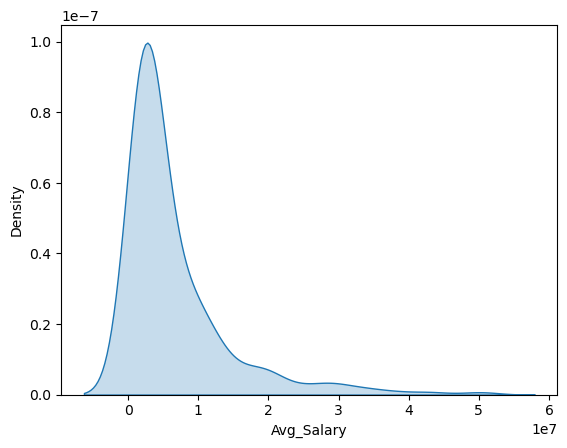

In [9]:
sns.kdeplot(data=X_train['Avg_Salary'], shade='true')
# salary is right-skewed

In [10]:
#Given how many data points are collected on each player, I used a Pearson R correlation to determine which data points are most correlated to salary
traditional_stats = ['PTS', 'TRB', 'AST','FGA','FG','FG.','X3P','X3PA','X2P.','STL','BLK','ORB','DRB','FT','FTA','G','GS','MP']
for x in traditional_stats:
    corr, _ = pearsonr(X_train[x],y_train)
    print('Pearsons correlation for %s: %.3f' %(x, corr))

Pearsons correlation for PTS: 0.761
Pearsons correlation for TRB: 0.428
Pearsons correlation for AST: 0.561
Pearsons correlation for FGA: 0.702
Pearsons correlation for FG: 0.749
Pearsons correlation for FG.: 0.077
Pearsons correlation for X3P: 0.407
Pearsons correlation for X3PA: 0.407
Pearsons correlation for X2P.: 0.020
Pearsons correlation for STL: 0.411
Pearsons correlation for BLK: 0.200
Pearsons correlation for ORB: 0.175
Pearsons correlation for DRB: 0.510
Pearsons correlation for FT: 0.695
Pearsons correlation for FTA: 0.664
Pearsons correlation for G: 0.343
Pearsons correlation for GS: 0.628
Pearsons correlation for MP: 0.656


In [11]:
advanced_stats = ['VORP','OWS','DWS','WS','WS.48','OBPM','DBPM','BPM','PER','TS.',"eFG."]
for x in advanced_stats:
    corr, _ = pearsonr(X_train[x],y_train)
    print('Pearsons correlation for %s: %.3f' %(x, corr))

Pearsons correlation for VORP: 0.745
Pearsons correlation for OWS: 0.698
Pearsons correlation for DWS: 0.537
Pearsons correlation for WS: 0.697
Pearsons correlation for WS.48: 0.281
Pearsons correlation for OBPM: 0.422
Pearsons correlation for DBPM: 0.006
Pearsons correlation for BPM: 0.353
Pearsons correlation for PER: 0.348
Pearsons correlation for TS.: 0.163
Pearsons correlation for eFG.: 0.088


**It seems that PTS (and things that lead to points like FG and FT) and VORP are the most strongly correlated to a player's salary**

[Text(0.5, 1.0, 'PTS v Avg Salary'),
 Text(0.5, 0, 'Average PPG in contract year'),
 Text(0, 0.5, 'Yearly Contract Value (in $10Ms)')]

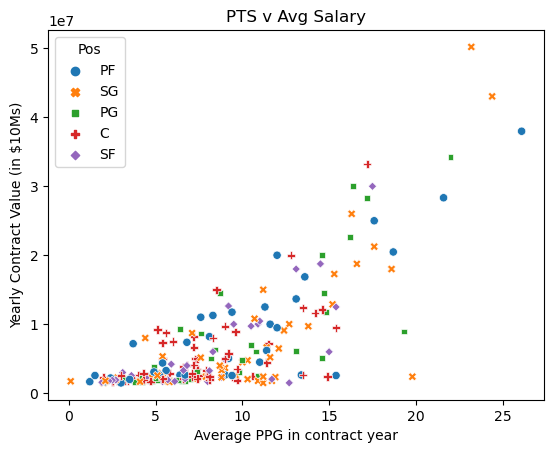

In [12]:
# PTS and salary has a very strong linear correlation
ax = sns.scatterplot(x='PTS',y=y_train, style = 'Pos', hue = "Pos", data = X_train)
ax.set(title="PTS v Avg Salary", xlabel="Average PPG in contract year", ylabel="Yearly Contract Value (in $10Ms)")

[Text(0.5, 1.0, 'PTS v Avg Salary regression for Centers'),
 Text(0.5, 0, 'Average PPG in contract year'),
 Text(0, 0.5, 'Yearly Contract Value (in $10Ms)')]

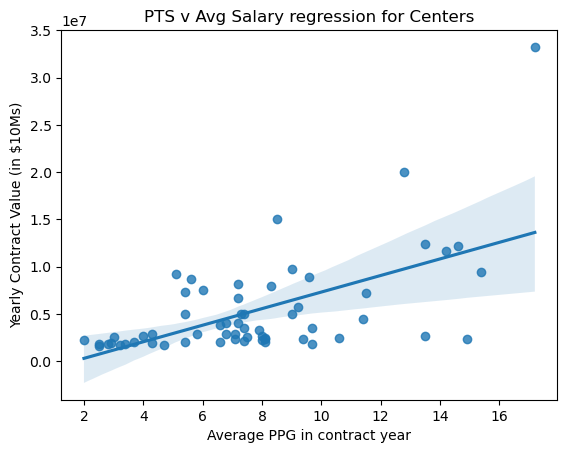

In [13]:
#It appears centers don't follow the linear pattern as closely as other positions
ax = sns.regplot(x='PTS', y= "Avg_Salary", data = X_train.loc[X_train.Pos == 'C'])
ax.set(title="PTS v Avg Salary regression for Centers", xlabel="Average PPG in contract year", ylabel="Yearly Contract Value (in $10Ms)")

[Text(0.5, 1.0, 'PTS v Avg Salary regression for non-Centers'),
 Text(0.5, 0, 'Average PPG in contract year'),
 Text(0, 0.5, 'Yearly Contract Value (in $10Ms)')]

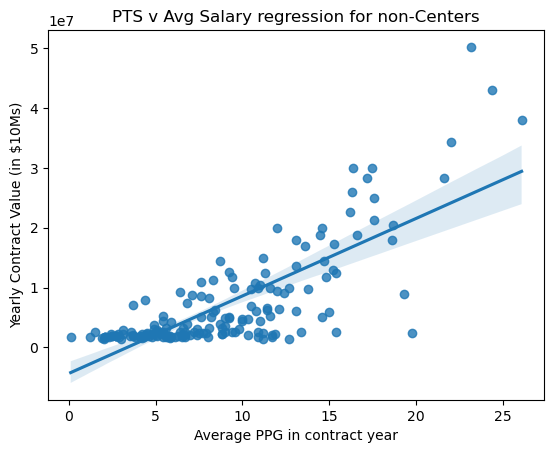

In [14]:
ax = sns.regplot(x='PTS',y='Avg_Salary', data = X_train.loc[X_train.Pos != 'C'])
ax.set(title="PTS v Avg Salary regression for non-Centers", xlabel="Average PPG in contract year", ylabel="Yearly Contract Value (in $10Ms)")

[Text(0.5, 1.0, 'VORP v Avg Salary'),
 Text(0.5, 0, 'VORP during contract year'),
 Text(0, 0.5, 'Yearly Contract Value (in $10Ms)')]

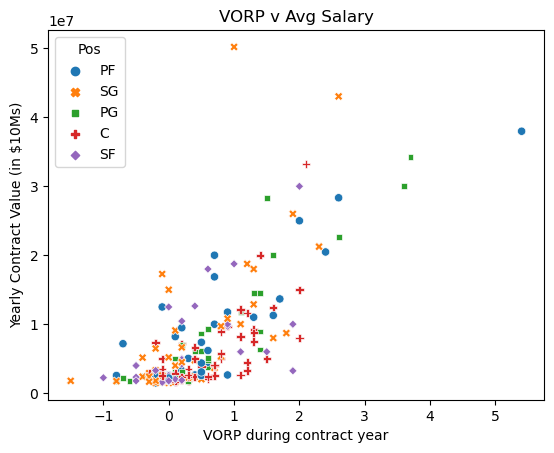

In [15]:
ax = sns.scatterplot(x='VORP',y='Avg_Salary', style = 'Pos', hue = "Pos", data = X_train)
ax.set(title="VORP v Avg Salary", xlabel="VORP during contract year", ylabel="Yearly Contract Value (in $10Ms)")

[Text(0.5, 1.0, 'VORP v Avg Salary'),
 Text(0.5, 0, 'VORP during contract year'),
 Text(0, 0.5, 'Yearly Contract Value (in $10Ms)')]

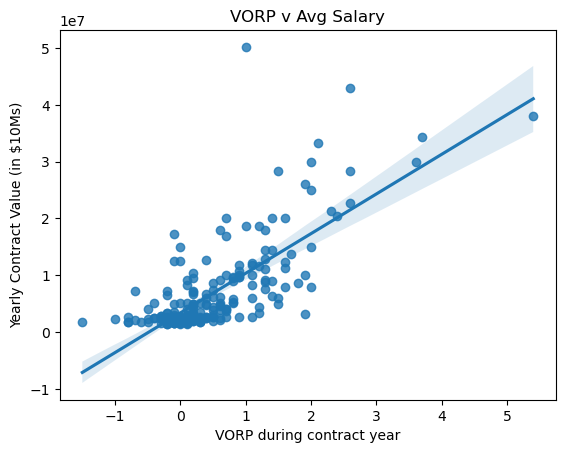

In [16]:
# VORP and salary has a strong linear correlation
ax = sns.regplot(x='VORP',y='Avg_Salary', data = X_train)
ax.set(title="VORP v Avg Salary", xlabel="VORP during contract year", ylabel="Yearly Contract Value (in $10Ms)")

Text(0.5, 1.0, 'Average Salary by position')

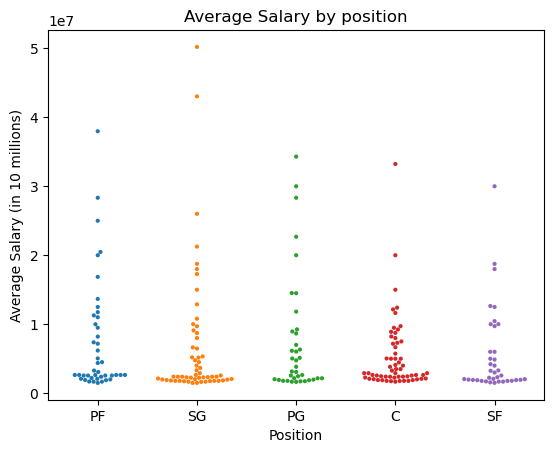

In [17]:
sns.swarmplot(x = 'Pos', y = 'Avg_Salary', s = 3, data = X_train)
plt.xlabel("Position")
plt.ylabel("Average Salary (in 10 millions)")
plt.title('Average Salary by position')
# In recent years the highest paid players have been SGs and SFs, but overall no position is being paid significantly more

#### Since certain positions are generally paid to do specific things in basketball (as we've seen PTS isn't as strong of an indicator for centers), I tried splitting the df into wings/guards and bigs

In [18]:
 wings_df = X_train[(X_train.Pos == "SF") | (X_train.Pos == "SG") | (X_train.Pos == "PG")]
wings_test = X_test[(X_test.Pos == "SF") | (X_test.Pos == "SG") | (X_test.Pos == "PG")]
print(len(wings_df), len(wings_test))

131 45


In [19]:
#Rechecking correlation values for the split dfs
y = wings_df['Avg_Salary']
traditional_stats = ['PTS', 'TRB', 'AST','FGA','FG','FG.','X3P','X3PA','X2P.','STL','BLK','ORB','DRB','FT','FTA','G','GS','MP']
for x in traditional_stats:
    corr, _ = pearsonr(wings_df[x],y)
    print('Pearsons correlation for %s: %.3f' %(x, corr))

Pearsons correlation for PTS: 0.768
Pearsons correlation for TRB: 0.563
Pearsons correlation for AST: 0.631
Pearsons correlation for FGA: 0.726
Pearsons correlation for FG: 0.763
Pearsons correlation for FG.: 0.170
Pearsons correlation for X3P: 0.511
Pearsons correlation for X3PA: 0.523
Pearsons correlation for X2P.: 0.040
Pearsons correlation for STL: 0.407
Pearsons correlation for BLK: 0.206
Pearsons correlation for ORB: 0.211
Pearsons correlation for DRB: 0.595
Pearsons correlation for FT: 0.694
Pearsons correlation for FTA: 0.671
Pearsons correlation for G: 0.295
Pearsons correlation for GS: 0.634
Pearsons correlation for MP: 0.653


In [20]:
y = wings_df['Avg_Salary']
advanced_stats = ['VORP','OWS','DWS','WS','WS.48','OBPM','DBPM','BPM','PER','TS.',"eFG."]
for x in advanced_stats:
    corr, _ = pearsonr(wings_df[x],y)
    print('Pearsons correlation for %s: %.3f' %(x, corr))

Pearsons correlation for VORP: 0.730
Pearsons correlation for OWS: 0.678
Pearsons correlation for DWS: 0.517
Pearsons correlation for WS: 0.685
Pearsons correlation for WS.48: 0.346
Pearsons correlation for OBPM: 0.532
Pearsons correlation for DBPM: 0.020
Pearsons correlation for BPM: 0.477
Pearsons correlation for PER: 0.529
Pearsons correlation for TS.: 0.193
Pearsons correlation for eFG.: 0.115


In [21]:
bigs_df = X_train[(X_train.Pos == "C")  | (X_train.Pos == "PF")]
bigs_test = X_test[(X_test.Pos == "C")  | (X_test.Pos == "PF")]

print(len(bigs_df), len(bigs_test))

103 34


In [22]:
y = bigs_df[['Avg_Salary']]
traditional_stats = ['PTS', 'TRB', 'AST','FGA','FG','FG.','X3P','X3PA','X2P.','STL','BLK','ORB','DRB','FT','FTA','G','GS','MP']
for x in traditional_stats:
    corr, _ = pearsonr(bigs_df[x],y)
    print('Pearsons correlation for %s: %.3f' %(x, corr))

Pearsons correlation for PTS: 0.752
Pearsons correlation for TRB: 0.520
Pearsons correlation for AST: 0.504
Pearsons correlation for FGA: 0.672
Pearsons correlation for FG: 0.732
Pearsons correlation for FG.: 0.063
Pearsons correlation for X3P: 0.281
Pearsons correlation for X3PA: 0.270
Pearsons correlation for X2P.: 0.028
Pearsons correlation for STL: 0.439
Pearsons correlation for BLK: 0.357
Pearsons correlation for ORB: 0.333
Pearsons correlation for DRB: 0.567
Pearsons correlation for FT: 0.715
Pearsons correlation for FTA: 0.688
Pearsons correlation for G: 0.428
Pearsons correlation for GS: 0.635
Pearsons correlation for MP: 0.671


In [23]:
y = bigs_df[['Avg_Salary']]
advanced_stats = ['VORP','OWS','DWS','WS','WS.48','OBPM','DBPM','BPM','PER','TS.',"eFG."]
for x in advanced_stats:
    corr, _ = pearsonr(bigs_df[x],y)
    print('Pearsons correlation for %s: %.3f' %(x, corr))

Pearsons correlation for VORP: 0.799
Pearsons correlation for OWS: 0.795
Pearsons correlation for DWS: 0.623
Pearsons correlation for WS: 0.792
Pearsons correlation for WS.48: 0.296
Pearsons correlation for OBPM: 0.328
Pearsons correlation for DBPM: 0.005
Pearsons correlation for BPM: 0.268
Pearsons correlation for PER: 0.273
Pearsons correlation for TS.: 0.165
Pearsons correlation for eFG.: 0.085


#### AST, TRB, and DRB stand out as factors more correlated with wing pay than big pay
#### DWS stands out as more important for big than wing pay

[Text(0.5, 1.0, 'AST v Avg Salary regression for Wings'),
 Text(0.5, 0, 'Average APG in contract year'),
 Text(0, 0.5, 'Yearly Contract Value (in $10Ms)')]

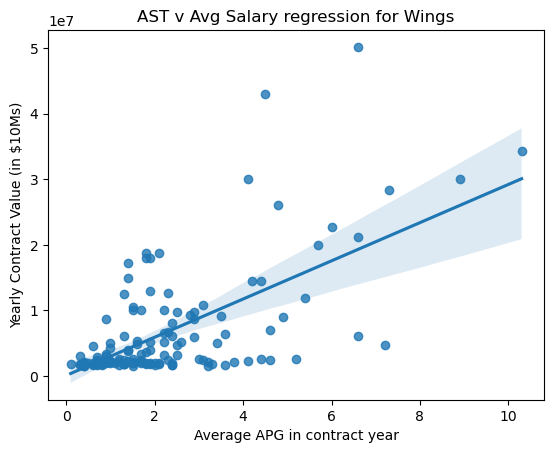

In [24]:
ax = sns.regplot(x='AST',y='Avg_Salary', data = wings_df)
ax.set(title="AST v Avg Salary regression for Wings", xlabel="Average APG in contract year", ylabel="Yearly Contract Value (in $10Ms)")

[Text(0.5, 1.0, 'DWS v Avg Salary regression for Bigs'),
 Text(0.5, 0, 'DWS in contract year'),
 Text(0, 0.5, 'Yearly Contract Value (in $10Ms)')]

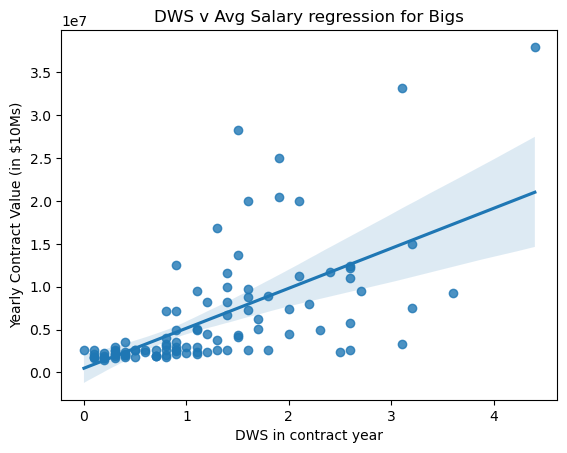

In [25]:
ax = sns.regplot(x='DWS',y='Avg_Salary', data = bigs_df)
ax.set(title="DWS v Avg Salary regression for Bigs", xlabel="DWS in contract year", ylabel="Yearly Contract Value (in $10Ms)")

## LINEAR REGRESSION MODELS ##

### ENTIRE DF ###

In [26]:
# use selected stats as predictor variable 
inputs = ['PTS', 'Age', 'AST', 'MP']
X = train_df[inputs]
# set y to avg_salary
y = y_train
# model
model = LinearRegression()
model.fit(X,y)
# Predict RMSE
y_predicted = model.predict(test_df[inputs])
rmse = mean_squared_error(test_df['Avg_Salary'], y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 4021360.892491329


### Guards/Wings DF ###

In [27]:
# use selected stats as predictor variable 
inputs = ['PTS', 'Age', 'VORP', 'AST', 'MP']
X_train = wings_df[inputs]
# set y to avg_salary
y_train = wings_df['Avg_Salary']
#model
model = LinearRegression()
model.fit(X_train,y_train)
# Predict RMSE
y_predicted = model.predict(wings_test[inputs])
rmse = mean_squared_error(wings_test['Avg_Salary'], y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 3627249.8495478686


### Bigs DF ###

In [28]:
# use selected stats as predictor variable 
inputs = ['PTS', 'Age']
X_train = bigs_df[inputs]
# set y to avg_salary
y_train = bigs_df['Avg_Salary']

model = LinearRegression()
model.fit(X_train,y_train)

# Predict RMSE
y_predicted = model.predict(bigs_test[inputs])
rmse = mean_squared_error(bigs_test['Avg_Salary'], y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 4258544.832592748


Overall, the linear regressions on the wings dataframes performed better than the linear regression on the overall dataframe while the bigs df performed similarly to the overall df. 

## DECISION TREE MODEL ##

In [29]:
# use selected stats as predictor variable 
inputs = ['PTS', 'Age', 'AST', 'MP']
X_train = train_df[inputs]
y_train = train_df['Avg_Salary']

In [30]:
max_depth_range = list(range(1, 25))
# List to store the average RMSE for each value of max_depth:
rmse_list = []
for depth in max_depth_range:
    model = DecisionTreeRegressor(max_depth = depth,
                            random_state = 0)
    model.fit(X_train, y_train)   
    
    y_predicted = model.predict(test_df[inputs])
    rmse = mean_squared_error(test_df['Avg_Salary'], y_predicted, squared=False)
    rmse_list.append(rmse)

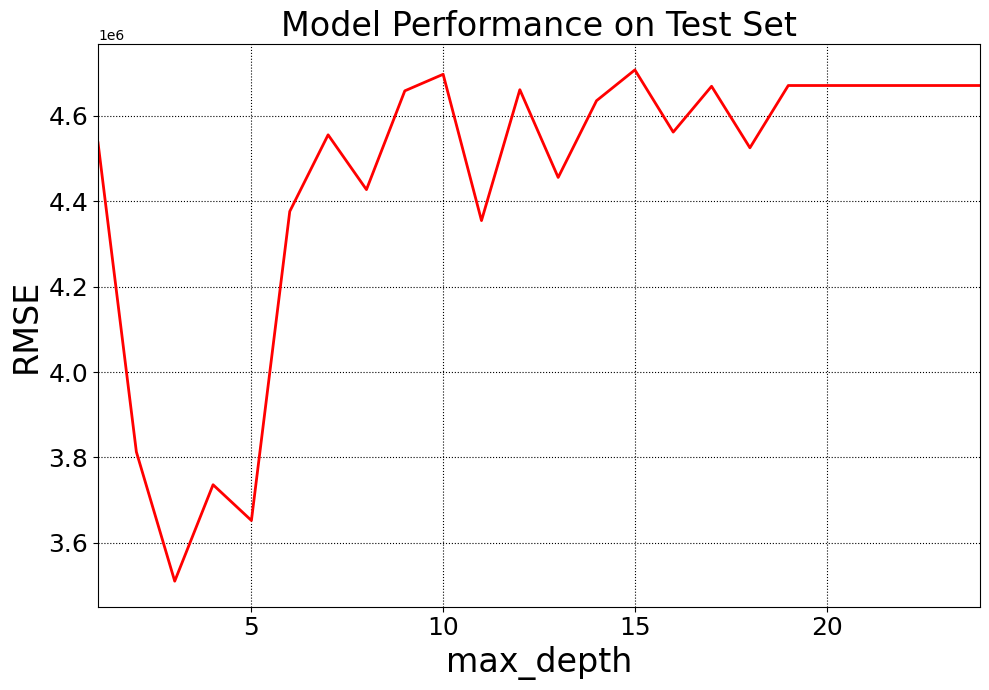

In [31]:
# graph of RMSE data
fig, ax = plt.subplots(nrows = 1, ncols = 1,
                        figsize = (10,7),
                        facecolor = 'white');
ax.plot(max_depth_range,
        rmse_list,
        lw=2,
        color='r')
ax.set_xlim([1, max(max_depth_range)])
ax.grid(True,
        axis = 'both',
        zorder = 0,
        linestyle = ':',
        color = 'k')
ax.tick_params(labelsize = 18)
ax.set_xlabel('max_depth', fontsize = 24)
ax.set_ylabel('RMSE', fontsize = 24)
ax.set_title('Model Performance on Test Set', fontsize = 24)
fig.tight_layout()

In [32]:
depth = 3
model = DecisionTreeRegressor(max_depth = depth, random_state=0)
model.fit(X_train,y_train)
# Predict RMSE
y_predicted = model.predict(test_df[inputs])
rmse = mean_squared_error(test_df['Avg_Salary'], y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 3510012.892404469


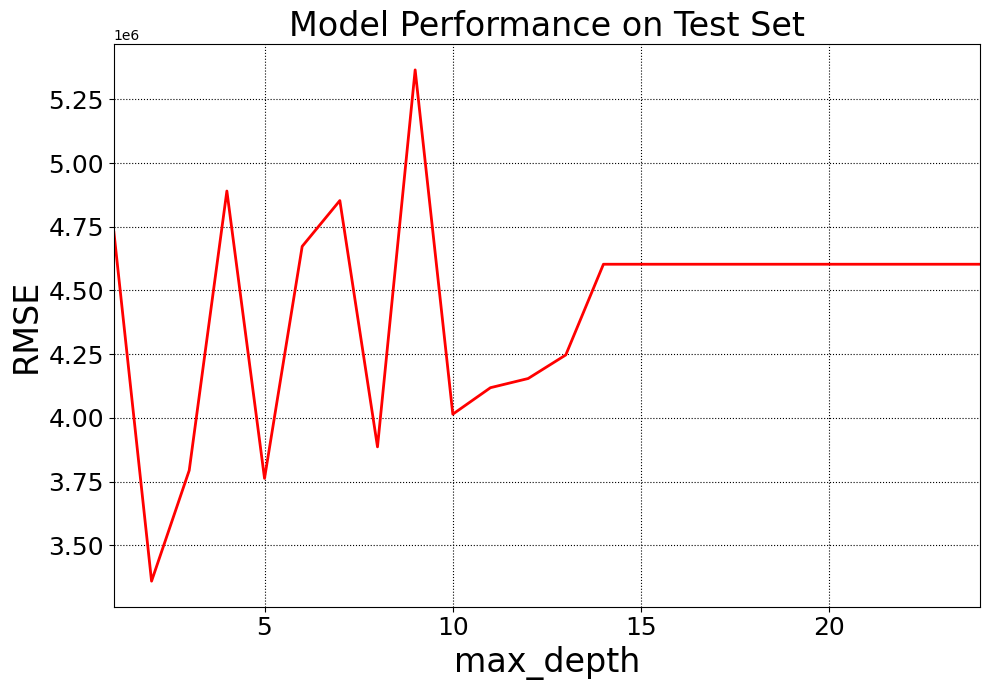

In [33]:
# use selected stats as predictor variable 
inputs = ['PTS', 'VORP', 'MP', 'AST']
X_train = wings_df[inputs]
# set y to avg_salary
y_train = wings_df['Avg_Salary']

max_depth_range = list(range(1, 25))
# List to store the average RMSE for each value of max_depth:
rmse_list = []
for depth in max_depth_range:
    model = DecisionTreeRegressor(max_depth = depth,
                            random_state = 0)
    model.fit(X_train, y_train)   
    
    y_predicted = model.predict(wings_test[inputs])
    rmse = mean_squared_error(wings_test['Avg_Salary'], y_predicted, squared=False)
    rmse_list.append(rmse)
# graph of RMSE data
fig, ax = plt.subplots(nrows = 1, ncols = 1,
                        figsize = (10,7),
                        facecolor = 'white');
ax.plot(max_depth_range,
        rmse_list,
        lw=2,
        color='r')
ax.set_xlim([1, max(max_depth_range)])
ax.grid(True,
        axis = 'both',
        zorder = 0,
        linestyle = ':',
        color = 'k')
ax.tick_params(labelsize = 18)
ax.set_xlabel('max_depth', fontsize = 24)
ax.set_ylabel('RMSE', fontsize = 24)
ax.set_title('Model Performance on Test Set', fontsize = 24)
fig.tight_layout()

In [34]:
depth = 2
model = DecisionTreeRegressor(max_depth = depth, random_state=0)
model.fit(X_train,y_train)
# Predict RMSE
y_predicted = model.predict(wings_test[inputs])
rmse = mean_squared_error(wings_test['Avg_Salary'], y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 3358754.3164338106


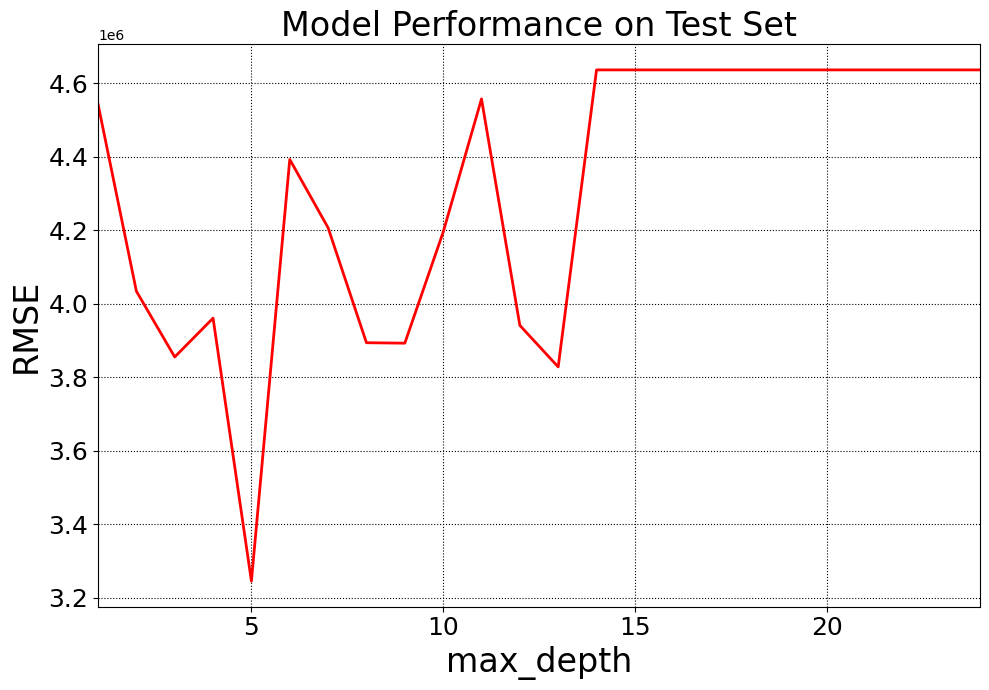

In [35]:
# use selected stats as predictor variable 
inputs = ['PTS', 'TRB', 'AST', 'Age']
X_train = bigs_df[inputs]
# set y to avg_salary
y_train = bigs_df['Avg_Salary']

max_depth_range = list(range(1, 25))
# List to store the average RMSE for each value of max_depth:
rmse_list = []
for depth in max_depth_range:
    model = DecisionTreeRegressor(max_depth = depth,
                            random_state = 0)
    model.fit(X_train, y_train)   
    
    y_predicted = model.predict(bigs_test[inputs])
    rmse = mean_squared_error(bigs_test['Avg_Salary'], y_predicted, squared=False)
    rmse_list.append(rmse)
# graph of RMSE data
fig, ax = plt.subplots(nrows = 1, ncols = 1,
                        figsize = (10,7),
                        facecolor = 'white');
ax.plot(max_depth_range,
        rmse_list,
        lw=2,
        color='r')
ax.set_xlim([1, max(max_depth_range)])
ax.grid(True,
        axis = 'both',
        zorder = 0,
        linestyle = ':',
        color = 'k')
ax.tick_params(labelsize = 18)
ax.set_xlabel('max_depth', fontsize = 24)
ax.set_ylabel('RMSE', fontsize = 24)
ax.set_title('Model Performance on Test Set', fontsize = 24)
fig.tight_layout()

In [36]:
depth = 5
model = DecisionTreeRegressor(max_depth = depth, random_state=0)
model.fit(X_train,y_train)
# Predict RMSE
y_predicted = model.predict(bigs_test[inputs])
rmse = mean_squared_error(bigs_test['Avg_Salary'], y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 3245357.7565744123


The decision tree outperformed the linear regression on all 3 dfs, the positional dfs also outperformed the overall df

## XGBOOST MODEL ##

In [37]:
# use selected stats as predictor variable 
inputs = ['PTS','Age', 'PER', 'GS', 'AST']
X_train = train_df[inputs]
# set y to avg_salary
y_train = train_df['Avg_Salary']

model = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 1)
model.fit(X_train,y_train)
# Predict RMSE
y_predicted = model.predict(test_df[inputs])
rmse = mean_squared_error(test_df['Avg_Salary'], y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 3206927.9554627873


In [38]:
# use selected stats as predictor variable 
inputs = ['PTS','Age','AST','DBPM', 'DRB']
X_train = wings_df[inputs]
# set y to avg_salary
y_train = wings_df['Avg_Salary']


wings_model = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 1)
wings_model.fit(X_train,y_train)
# Predict RMSE
y_predicted = wings_model.predict(wings_test[inputs])
rmse = mean_squared_error(wings_test['Avg_Salary'], y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 3061142.8495050226


In [39]:
# use selected stats as predictor variable 
inputs = ['PTS', 'TRB', 'AST', 'Age', 'DWS']
X_train = bigs_df[inputs]
# set y to avg_salary
y_train = bigs_df['Avg_Salary']

bigs_model = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 1)
bigs_model.fit(X_train,y_train)
# Predict RMSE
y_predicted = bigs_model.predict(bigs_test[inputs])
rmse = mean_squared_error(bigs_test['Avg_Salary'], y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 3319909.5891592028


Overall, for looking at the entire DF, the xgboost models and decision tree models performed the best. The bigs and wings models consistently outperformed the total models by a decent amount.
I will be using the XGBoost model as the predictor model

In [40]:
#Using Jalen Brunson as example
player = pd.DataFrame(np.array([[1]]),
                   columns=['a'])
player = player.drop(['a'], axis = 1)
player['Pos'] = input("Insert position: ")
player["PTS"] = float(input("Insert ppg: "))
player['TRB'] = float(input("Insert rpg: "))
player['DRB'] = float(input("Insert defensive rpg: "))
player['AST'] = float(input("Insert apg: "))
player['Age'] = int(input("Insert age: "))
player['DWS'] = float(input("Insert dws: "))
player['DBPM'] = float(input("Insert dbpm: "))
player.head()

Insert position: PG
Insert ppg: 16.3
Insert rpg: 3.9
Insert defensive rpg: 3.4
Insert apg: 4.8
Insert age: 25
Insert dws: 2.7
Insert dbpm: 0


,Pos,PTS,TRB,DRB,AST,Age,DWS,DBPM
0,PG,16.3,3.9,3.4,4.8,25,2.7,0.0


In [41]:
if (player.Pos == "PG")[0] | (player.Pos == "SG")[0] | (player.Pos == "SF")[0]:
    model = wings_model
    inputs = ['PTS','Age','AST','DBPM', 'DRB'] 
elif (player.Pos == "PF")[0] | (player.Pos == "C")[0]:
    model = bigs_model
    inputs = ['PTS', 'TRB', 'AST', 'Age', 'DWS']

In [42]:
print("Projected contract value per year: $", model.predict(player[inputs])[0])

Projected contract value per year: $ 24969144.0
